## Kaggle Credit Data Project

Learning goals:   
- Using ipython notebook for documentation and data exploration.
- Become familar with explorative data analysis with pandas.
- Data cleansing (detecting outliers etc.)
- Training and predictions 

### Explorative Data Analyis and Data Cleansing

#### Description of the variables

*Nominal*
- Target Variable `SeriousDlqin2yrs` [Y/N]: Person experienced 90 days past due delinquency or worse. 

Features: 

*Ordinal*
- `RevolvingUtilizationOfUnsecuredLines` [percentage]: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits.
- `NumberOfTime30-59DaysPastDueNotWorse` [integer]: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
- `NumberOfOpenCreditLinesAndLoans` [integer]: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
- `NumberOfTimes90DaysLate` [integer]: Number of times borrower has been 90 days or more past due.
- `NumberRealEstateLoansOrLines` [integer]: Number of mortgage and real estate loans including home equity lines of credit
- `NumberOfTime60-89DaysPastDueNotWorse` [integer]: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
- `NumberOfDependents` [integer]: Number of dependents in family excluding themselves (spouse, children etc.)

*Ratio*
- `DebtRatio` [percentage]: Monthly debt payments, alimony,living costs divided by monthy gross income
- `age` [integer]: Age of borrower in years; 
- `MonthlyIncome` [real]: Monthly income

**Import of libraries and establish easily accessible column names**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import collections
%matplotlib inline
import matplotlib.pyplot as plt

# read the data into a pandas data frame
df = pd.read_csv('./cs-training.csv')
del df['Unnamed: 0']

cleanColumns = []
for i in range (len(df.columns)):
    cleanColumns.append(df.columns[i].replace('-',''))

df.columns = cleanColumns

**Have a look at the data**

In [3]:
#print(df.describe())

### Replacement of NaN Values

In [4]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
df.MonthlyIncome = imp.fit_transform(df.MonthlyIncome.reshape(-1, 1))
df.NumberOfDependents = imp.fit_transform(df.NumberOfDependents.reshape(-1, 1))
#print(df.head(20)) # check if it worked

### Outlier detection and replacement

In [4]:
# use 95%-Quantil / slow method
def compute_percentile_outliers(x, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(x, [diff, 100 - diff])
    print(minval, maxval)
    return (x < minval) | (x > maxval) #return boolean array with all outliers marked true

In [5]:
#replace all marked outliers with the median of the column (vote=outliers)
def replace_outliers_median(vote, data):
    x = pd.DataFrame(list(zip(data, vote)), columns=['data', 'outlier'])
    replace = x.data.median()
    debtNew = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            debtNew.append(replace) #append median
        else:
            debtNew.append(x.iloc[i][0]) #append belonging data
    return debtNew

0.0 0.9999999


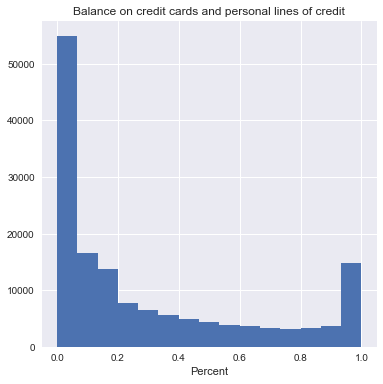

In [6]:
#fix outliers in revolving utilization of unsecured lines
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
rev_outliers = compute_percentile_outliers(df.RevolvingUtilizationOfUnsecuredLines)
x = replace_outliers_median(rev_outliers,df.RevolvingUtilizationOfUnsecuredLines)
ax.hist(x, bins = 15)
ax.set_title('Balance on credit cards and personal lines of credit')
ax.set_xlabel('Percent')

In [ ]:
#try seaborn for visualization
#fig, axes = plt.subplots(nrows=1)
#sns.distplot(x, ax=axes, rug=True)

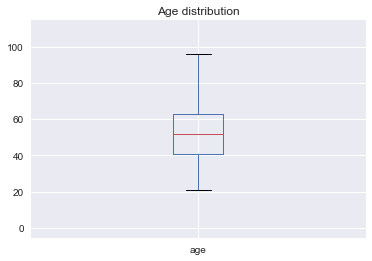

In [7]:
ax = df.age.plot.box()
ax.set_title('Age distribution')

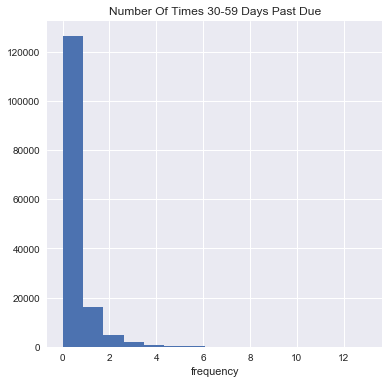

In [8]:
#outliers of 95 and 98 for all past due times
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
df.loc[df['NumberOfTime3059DaysPastDueNotWorse'] > 95,'NumberOfTime3059DaysPastDueNotWorse'] = df.NumberOfTime3059DaysPastDueNotWorse.median()
df3 = df.NumberOfTime3059DaysPastDueNotWorse
ax.hist(df3, bins = 15, range = (df3.min(), df3.max()))
ax.set_title('Number Of Times 30-59 Days Past Due')
ax.set_xlabel('frequency')

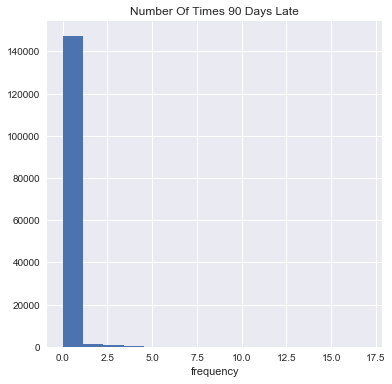

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
df.loc[df.NumberOfTimes90DaysLate > 95,'NumberOfTimes90DaysLate'] = df.NumberOfTimes90DaysLate.median()
df4 = df.NumberOfTimes90DaysLate
ax.hist(df4, bins = 15, range = (df4.min(), df4.max()))
ax.set_title('Number Of Times 90 Days Late')
ax.set_xlabel('frequency')

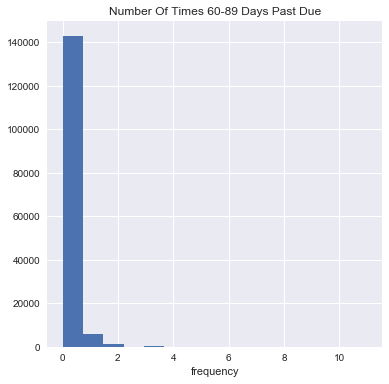

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
df.loc[df.NumberOfTime6089DaysPastDueNotWorse > 95,'NumberOfTime6089DaysPastDueNotWorse'] = df.NumberOfTime6089DaysPastDueNotWorse.median()
df6 = df.NumberOfTime6089DaysPastDueNotWorse
ax.hist(df6, bins = 15, range = (df6.min(), df6.max()))
ax.set_title('Number Of Times 60-89 Days Past Due')
ax.set_xlabel('frequency')

0.0 3489.025


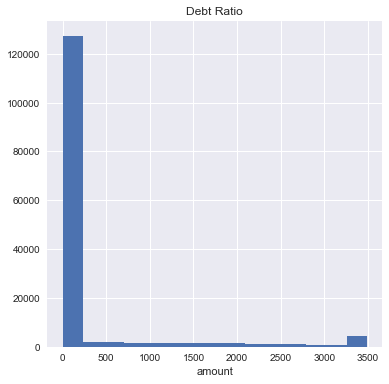

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
minUpperBound = min([val for (val, out) in zip(df.DebtRatio, compute_percentile_outliers(df.DebtRatio)) if out == True])
df.loc[df.DebtRatio > minUpperBound,'DebtRatio'] = minUpperBound
dR = df.DebtRatio
ax.hist(dR, bins = 15, range = (dR.min(), dR.max()))
ax.set_title('Debt Ratio')
ax.set_xlabel('amount')

820.0 16866.0


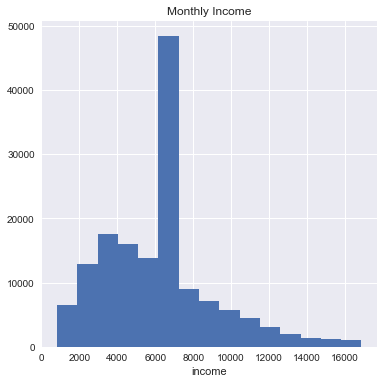

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
outliers = compute_percentile_outliers(df.MonthlyIncome)
dfmI = replace_outliers_median(outliers, df.MonthlyIncome)
df.MonthlyIncome = dfmI
#minUpperBoundMI = min([j for (j, outI) in zip(df.MonthlyIncome, outliers) if outI == True])
#print(minUpperBoundMI)
#realIncome = []
#for i in df.MonthlyIncome:
#    if i > minUpperBoundMI:
#        realIncome.append(minUpperBoundMI)
#    else:
#        realIncome.append(i)
#df.MonthlyIncome = realIncome
ax.hist(df.MonthlyIncome, bins = 15)
ax.set_title('Monthly Income')
ax.set_xlabel('income')
#print(collections.Counter(dfmI))

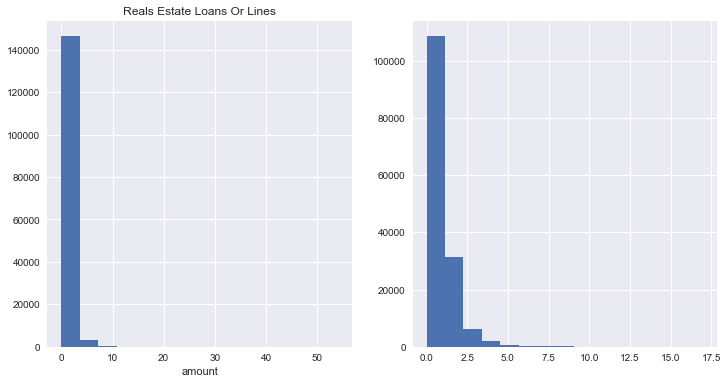

In [13]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
loansAndLines = df.NumberRealEstateLoansOrLines
#print(collections.Counter(loansAndLines))
ax.hist(df.NumberRealEstateLoansOrLines, bins = 15, range = (loansAndLines.min(), loansAndLines.max()))
df.loc[df.NumberRealEstateLoansOrLines > 17,'NumberRealEstateLoansOrLines'] = 17
ax2.hist(df.NumberRealEstateLoansOrLines, bins = 15, range = (df.NumberRealEstateLoansOrLines.min(), df.NumberRealEstateLoansOrLines.max()))
ax.set_title('Reals Estate Loans Or Lines')
ax.set_xlabel('amount')
# attention to different levels of measurement for each visualization!

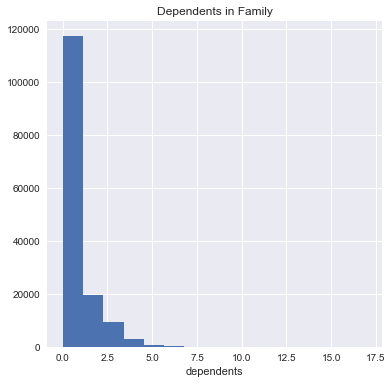

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
dependents = df.NumberOfDependents
#print(collections.Counter(dependents))
df.loc[dependents > 17,'NumberOfDependents'] = 17
ax.hist(dependents, bins = 15, range = (dependents.min(), dependents.max()))
ax.set_title('Dependents in Family')
ax.set_xlabel('dependents')

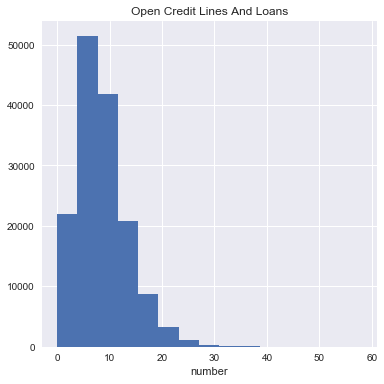

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
openCredit = df.NumberOfOpenCreditLinesAndLoans
#print(collections.Counter(openCredit))
ax.hist(openCredit, bins = 15, range = (openCredit.min(), openCredit.max()))
ax.set_title('Open Credit Lines And Loans')
ax.set_xlabel('number')

### correlation between variables

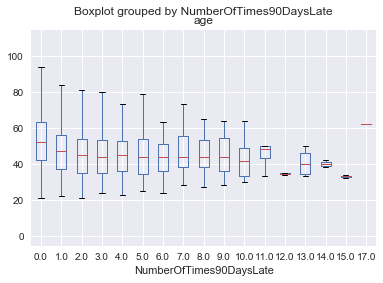

In [16]:
df.boxplot(column='age', by='NumberOfTimes90DaysLate')

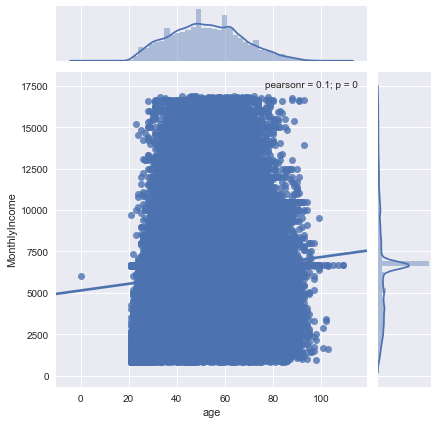

In [117]:
sns.jointplot("age", "MonthlyIncome", df, kind='reg')

In [ ]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(24,24))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Feature Correlation')
    labels=df.columns
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(df)

### Training of data

#### Training and Prediction

- Split the data set for training, validation and testing
- Training and evaluation (use the `sklearn.metrics.roc_auc_score` metrics.)
  - Train a classifier with your logistic regression code (incl. data scaling)
    - Plot the appropritate error for different regularization values lambda
    - What is the expected performance on new data?
  - Use different appropriate algorithms of sklearn and evaluate the results.  

In [98]:
from sklearn.cross_validation import train_test_split
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df.SeriousDlqin2yrs
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

##### kNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

#only split in test and train, not validation
X_knn = df.drop('SeriousDlqin2yrs', axis=1)
y_knn = df.SeriousDlqin2yrs
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, train_size=0.4, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

knMod = KNeighborsClassifier(n_neighbors=5)
cvScore = cross_val_score(knMod, X_train_knn, y_train_knn, cv=5)
print(cvScore.mean())
knMod.fit(X_train_knn, y_train_knn)
y2_model = knMod.predict(X_test_knn)
accuracy_score(y_test_knn, y2_model)

0.930749987115


0.93159999999999998

##### sklearn Logistic Regression

In [100]:
#Regulierungsterm C verwenden!!! 

from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression()
cvScore = cross_val_score(logReg, X_train, y_train, cv=3)
cvScore.mean()

0.93687499413216135

In [121]:
regr = LogisticRegression().fit(X_train, y_train)
print(str(regr.score(X_train, y_train)))
arr = regr.predict(X_train)
prob = (len(arr) - np.count_nonzero(arr) ) / len(arr)
print(prob)

0.937458333333
0.9852083333333334


In [122]:
arr_test = regr.predict(X_test)
prob_test = (len(arr_test) - np.count_nonzero(arr_test) ) / len(arr_test)
print(prob_test)

0.9850916666666667


In [123]:
#regr = LogisticRegression().fit(X_val, y_val)
#print(str(regr.score(X_val, y_val)))
arr_val = regr.predict(X_val)
prob = (len(arr_val) - np.count_nonzero(arr_val) ) / len(arr_val)
print(prob)

0.9836666666666667


##### Naive Bayes

In [101]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
model = clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
model = clf.predict(X_train)
accuracy_score(y_train, model)

0.91908333333333336

In [102]:
model = clf.predict(X_test)
accuracy_score(y_test, model)

0.91749999999999998

In [103]:
model = clf.predict(X_val)
accuracy_score(y_val, model)

0.91633333333333333

##### own logistic regression

In [114]:
def logistic_hypothesis(theta):
    return lambda x: 1 / (1 + np.exp(-x.dot(theta)))

def cross_entropy_loss(h, X, y):
    return lambda theta: (-y * (np.log(h(X))))-((1-y) * (np.log(1 - h(X))))

def reg_cost(loss, lambda_reg, x):
    return lambda theta: (loss(theta) + ((lambda_reg / len(x)) * (theta[1:,].T).dot(theta[1:,]))).mean()

def reg_gradient_descent(lambda_reg, alpha, theta, nb_iterations, x, y):   
    for i in range(nb_iterations):
        h = logistic_hypothesis(theta)
        loss = cross_entropy_loss(h,x,y)
        cost = reg_cost(loss, lambda_reg, x)
        grad = np.zeros(theta.shape[0])
        for i in range(theta.shape[0]):
            if (i == 0):
                grad[i] = reg_compute_new_theta(x,y,theta, alpha, h)[i]
            else:
                grad[i] = reg_compute_new_theta(x,y,theta, alpha, h)[i] + ((lambda_reg / len(x)) * theta[i])
        theta = grad
  
    return theta

def feature_scaling(x):
    #mean = np.mean(x.loc[:,1:], axis= 0)
    #std = np.std(x.loc[:,1:], axis=0)
    #fs_x = (x.loc[:,1:] - mean) / std
    #x = np.c_[x.loc[:,0],fs_x]
    mean = x[:,1:].mean(axis=0)
    std = x[:,1:].std(axis=0)
    x[:,1:] = (x[:,1:] - mean) / std
    return x

def reg_compute_new_theta(x, y, theta, alpha, h):
    temp = (1./len(x)) * ((h(x)-y).dot(x))
    new_theta = theta - alpha/len(x) * temp
    return new_theta

def classify(X, y, h):
    p = np.zeros(shape=(len(X),))
    h = h(X)
    print (type(h))
    p[h>0.5]=1
    #for it in range(0, len(h)):
    #    if h[it] > 0.5:
    #        p[it] = 1
    found = np.sum(p == y)
    result = ( found / float(y.size)) * 100.0
    return (result), p

In [116]:
alpha_reg = 0.01
theta_reg = np.array([1,0,0,0,0,0,0,0,0,0])
#x_train = feature_scaling(X_train)
theta_reg = reg_gradient_descent(1, alpha_reg, theta_reg, 100, X_train, y_train)
#print(theta_reg)
result, c_error = classify(X_train,y_train,logistic_hypothesis(theta_reg))
print('Train Accuracy: %f' % result)
#print(y_train, c_error)
score = roc_auc_score(y_train, c_error)
print("Roc-Auc-Score: " + str(score))

<class 'pandas.core.series.Series'>
Train Accuracy: 92.475000
Roc-Auc-Score: 0.514533183106
